<a href="https://colab.research.google.com/github/WeiShaoD/Scripts/blob/main/Gambling_project_of_hcp_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load HCP parcellated task data

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import seaborn as sns

In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
#    'MOTOR'      : {'runs': [5,6],   'cond':['lf','rf','lh','rh','t','cue']},
#    'WM'         : {'runs': [7,8],   'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
#    'EMOTION'    : {'runs': [9,10],  'cond':['fear','neut']},
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss','win','neut']}
#    'LANGUAGE'   : {'runs': [13,14], 'cond':['math','story']},
#    'RELATIONAL' : {'runs': [15,16], 'cond':['match','relation']},
#    'SOCIAL'     : {'runs': [17,18], 'cond':['mental','rnd']}
}

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

In [ ]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# print(regions.shape)
# print(region_info)

In [ ]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int):      0-based subject ID to load
    experiment (str):   Name of experiment 
    run (int):          0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = EXPERIMENTS[experiment]['runs'][run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = 'tfMRI_'+experiment+'_'+['RL','LR'][run]
  for cond in EXPERIMENTS[experiment]['cond']:    
    ev_file  = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{cond}_event.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list


In [ ]:
my_exp  = 'GAMBLING'
my_subj = 0
my_run  = 1

data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)

print(data.shape)

(360, 253)


Text(0.5, 1.0, 'Resting Regressor')

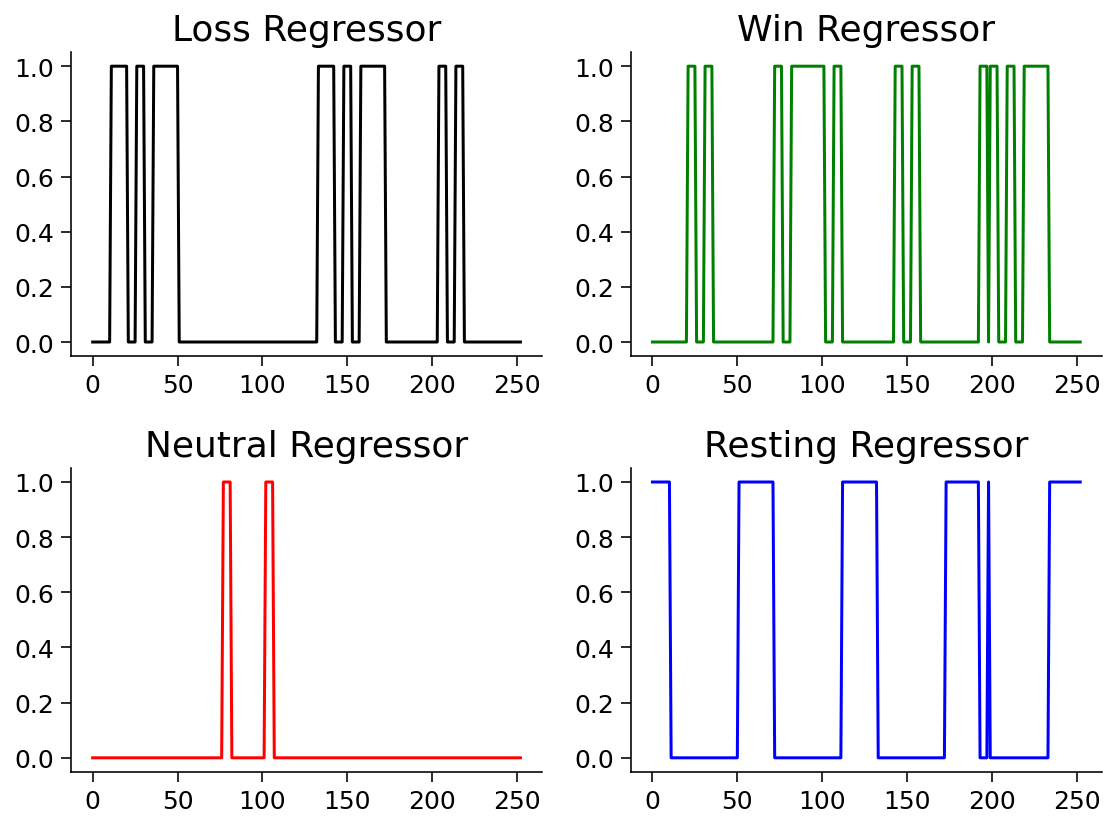

In [ ]:
evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)
# lets visualzie the loss regressor
# print((evs[2]))
los_reg = np.zeros(253)
win_reg = np.zeros(253)
net_reg = np.zeros(253)
res_reg = np.ones(253)
for id in range(0,len(evs[0])):
    los_reg[evs[0][id]] = 1
# lets visualize the win regressor
for id in range(0,len(evs[1])):
    win_reg[evs[1][id]] = 1
# lets visualize the neut regressor
for id in range(0,len(evs[2])):
    net_reg[evs[2][id]] = 1
#let screate the resting phase regressor
for id in range(0,len(evs[0])):
    res_reg[evs[0][id]] = 0
for id in range(0,len(evs[1])):
    res_reg[evs[1][id]] = 0  
for id in range(0,len(evs[2])):
    res_reg[evs[2][id]] = 0    
# win_reg[evs[1][0]] = 1
# win_reg[evs[1][1]] = 1
fig, axs = plt.subplots(2,2)
axs[0,0].plot(los_reg, 'k')
axs[0, 0].set_title('Loss Regressor')
axs[0,1].plot(win_reg, 'g')
axs[0, 1].set_title('Win Regressor')
axs[1,0].plot(net_reg, 'r')
axs[1, 0].set_title('Neutral Regressor')
axs[1,1].plot(res_reg, 'b')
axs[1, 1].set_title('Resting Regressor')

In [ ]:
xxx = np.vstack((los_reg, win_reg, net_reg, res_reg))
xxx.shape

(4, 253)

In [ ]:
# # Lets study the matrix shapes before running a GLM
# # los_reg.sum()+win_reg.sum()+net_reg.sum()+res_reg.sum()
x = np.vstack((los_reg, win_reg, net_reg, res_reg)).T
y = data.T
a = np.matmul(x.T, x)
# print(a.shape)
a_inv = np.linalg.inv(a)
# print(a_inv.shape)
b = np.matmul(x.T, y)
# print(b.shape)
beta = np.matmul(a_inv, b)
print(beta.shape)
# plt.plot(beta)
# b = np.matmul(np.linalg.inv(np.matmul(x.T,x)), np.matmul(x.T,y))

(4, 360)


In [ ]:
def glm(data,reg):
    constant = np.ones(253)
    X = np.vstack((reg, constant)).T
    y = data
  
    # Calculate the dot product of the transposed design matrix and the design matrix
    # and invert the resulting matrix.
    tmp   = np.linalg.inv(X.transpose().dot(X))
    
    # Now calculate the dot product of the above result and the transposed design matrix
    tmp   = tmp.dot(X.transpose())

    # Pre-allocate variables
    beta  = np.zeros((y.shape[0], X.shape[1]))
    e     = np.zeros(y.shape)
    model = np.zeros(y.shape)
    r     = np.zeros(y.shape[0])
    
    # Find beta values for each voxel and calculate the model, error and the correlation coefficients 
    for i in range(y.shape[0]):
        beta[i]  = tmp.dot(y[i,:].transpose())
        model[i] = X.dot(beta[i])
        e[i]     = (y[i,:] - model[i])
        r[i]     = np.sqrt(model[i].var()/y[i,:].var())
    
   
    return beta, model, e, r
   
# a = np.matmul(x.T, x)
    # print(a.shape)
#    a_inv = np.linalg.inv(a)
    # print(a_inv.shape)
#    b = np.matmul(x.T, y)
    # print(b.shape)
#    beta = np.matmul(a_inv, b)
#    return beta
  

In [ ]:
X = np.vstack((los_reg, win_reg, net_reg, res_reg)).T
y = data
  
    # Calculate the dot product of the transposed design matrix and the design matrix
    # and invert the resulting matrix.
print(X.shape,y.shape)
print(X.transpose().dot(X).shape)
print(np.linalg.inv(X.transpose().dot(X)))
print(los_reg.shape,constant.shape)
tmp   = np.linalg.inv(X.transpose().dot(X))
print(tmp.shape)   
    # Now calculate the dot product of the above result and the transposed design matrix
tmp   = tmp.dot(X.transpose())
print(tmp.shape)
    # Pre-allocate variables
beta  = np.zeros((y.shape[0], X.shape[1]))
e     = np.zeros(y.shape)
model = np.zeros(y.shape)
r     = np.zeros(y.shape[0])
print(beta.shape, e.shape, model.shape, r.shape)    
    # Find beta values for each voxel and calculate the model, error and the correlation coefficients 
#for i in range(y.shape[0]):
#  beta[i]  = tmp.dot(y[i,:].transpose())
#  model[i] = X.dot(beta[i])
#  e[i]     = (y[i,:] - model[i])
#  r[i]     = np.sqrt(model[i].var()/y[i,:].var())

(253, 4) (360, 253)
(4, 4)
[[0.01428571 0.         0.         0.        ]
 [0.         0.0125     0.         0.        ]
 [0.         0.         0.1        0.        ]
 [0.         0.         0.         0.01075269]]
(253,) (253,)
(4, 4)
(4, 253)
(360, 4) (360, 253) (360, 253) (360,)


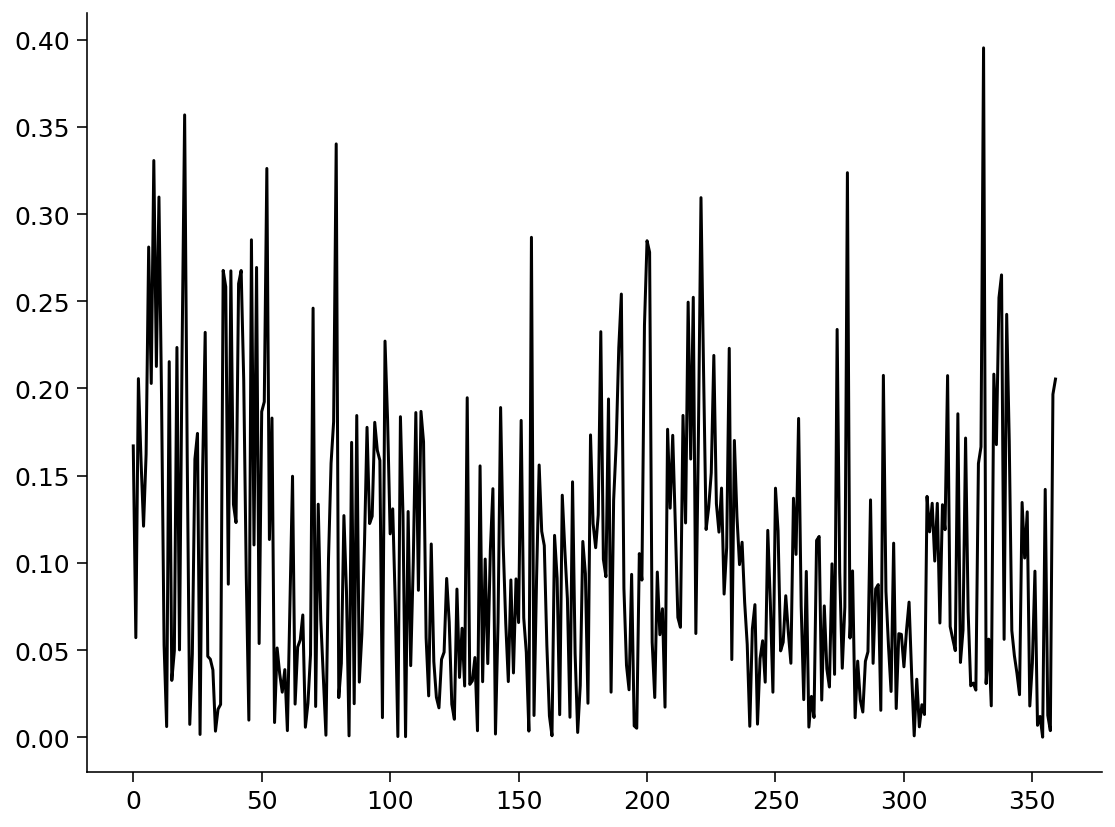

In [ ]:
my_exp  = 'GAMBLING'
my_subj = 0
my_run  = 1

# loading the timeseries data
data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)
# loading the EVs
evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)
# lets visualzie the loss regressor

constant = np.ones(253)
los_reg = np.zeros(253)
win_reg = np.zeros(253)
net_reg = np.zeros(253)
res_reg = np.ones(253)
for id in range(0,len(evs[0])):
    los_reg[evs[0][id]] = 1
# lets visualize the win regressor
for id in range(0,len(evs[1])):
    win_reg[evs[1][id]] = 1
# lets visualize the neut regressor
for id in range(0,len(evs[2])):
    net_reg[evs[2][id]] = 1
#let screate the resting phase regressor
for id in range(0,len(evs[0])):
    res_reg[evs[0][id]] = 0
for id in range(0,len(evs[1])):
    res_reg[evs[1][id]] = 0  
for id in range(0,len(evs[2])):
    res_reg[evs[2][id]] = 0 

beta, model, e, r = glm(data,res_reg)
# plt.plot(model,"k")
plt.plot(r,"k")

In [ ]:
# Lets bring together the previous steps all in one for running through all subjects, all runs
betas_los = np.zeros((2, 360, 2, 339))
betas_win = np.zeros((2, 360, 2, 339))
betas_net = np.zeros((2, 360, 2, 339))
betas_res = np.zeros((2, 360, 2, 339))
r_los = np.zeros((1,360,2,339))
r_win = np.zeros((1,360,2,339))
r_net = np.zeros((1,360,2,339))
r_res = np.zeros((1,360,2,339))
for sub_id in subjects:                     
    my_exp  = 'GAMBLING'
    my_subj = sub_id
#  beta_tmp = np.zeros((4, 360, 2, 1))
    for run in [0,1]:
        my_run  = run
        #load data
        data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)
        # load the evs and create gressors
        evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)
        # lets visualzie the loss regressor
        # print((evs[2]))
        los_reg = np.zeros(253)
        win_reg = np.zeros(253)
        net_reg = np.zeros(253)
        res_reg = np.ones(253)
        for id in range(0,len(evs[0])): los_reg[evs[0][id]] = 1
        # lets visualize the win regressor
        for id in range(0,len(evs[1])): win_reg[evs[1][id]] = 1
        # lets visualize the neut regressor
        for id in range(0,len(evs[2])): net_reg[evs[2][id]] = 1
        #let screate the resting phase regressor
        for id in range(0,len(evs[0])): res_reg[evs[0][id]] = 0
        for id in range(0,len(evs[1])): res_reg[evs[1][id]] = 0  
        for id in range(0,len(evs[2])): res_reg[evs[2][id]] = 0
        
        betas_los_tmp, model_los_tmp, e_los_tmp, r_los_tmp = glm(data, los_reg)
        betas_win_tmp, model_win_tmp, e_win_tmp, r_win_tmp = glm(data, win_reg)
        betas_net_tmp, model_net_tmp, e_net_tmp, r_net_tmp = glm(data, net_reg)
        betas_res_tmp, model_res_tmp, e_res_tmp, r_res_tmp = glm(data, res_reg)
        r_los[:, :, run, sub_id] = r_los_tmp
        r_win[:, :, run, sub_id] = r_win_tmp
        r_net[:, :, run, sub_id] = r_net_tmp
        r_res[:, :, run, sub_id] = r_res_tmp
        betas_los[:, :, run, sub_id] = betas_los_tmp.T
        betas_win[:, :, run, sub_id] = betas_win_tmp.T
        betas_net[:, :, run, sub_id] = betas_net_tmp.T
        betas_res[:, :, run, sub_id] = betas_res_tmp.T


In [ ]:
betas_avg_sub_run_los = betas_los.mean(axis = 2).mean(axis = 2)
betas_avg_sub_run_win = betas_win.mean(axis = 2).mean(axis = 2)
betas_avg_sub_run_net = betas_net.mean(axis = 2).mean(axis = 2)
betas_avg_sub_run_res = betas_res.mean(axis = 2).mean(axis = 2)
#print(betas_all.shape)
#print(betas_avg_sub_run.shape)
#print(betas_all.mean(axis=2).shape)

(2, 360, 2, 339)
(4, 360)
(2, 360, 339)


In [ ]:
r_avg_sub_run_los = r_los.mean(axis = 2).mean(axis = 2)
r_avg_sub_run_win = r_win.mean(axis = 2).mean(axis = 2)
r_avg_sub_run_net = r_net.mean(axis = 2).mean(axis = 2)
r_avg_sub_run_res = r_res.mean(axis = 2).mean(axis = 2)
print(r_all.shape)
print(r_avg_sub_run.shape)
print(r_all.mean(axis=2).shape)

(1, 360, 2, 339)
(1, 360)
(1, 360, 339)


Text(0.5, 1.0, 'Resting Regressor')

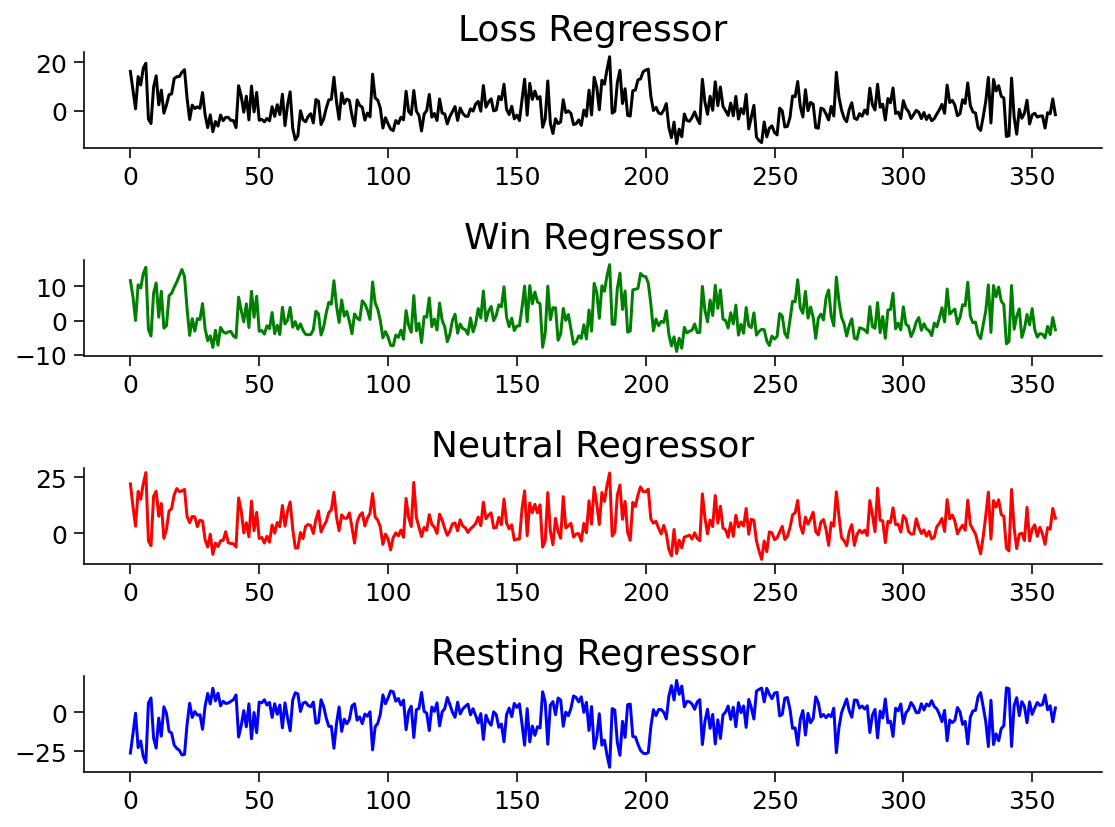

In [ ]:
fig, axs = plt.subplots(4)
axs[0].plot(betas_avg_sub_run[0,:], 'k')
axs[0].set_title('Loss Regressor')
axs[1].plot(betas_avg_sub_run[1,:], 'g')
axs[1].set_title('Win Regressor')
axs[2].plot(betas_avg_sub_run[2,:], 'r')
axs[2].set_title('Neutral Regressor')
axs[3].plot(betas_avg_sub_run[3,:], 'b')
axs[3].set_title('Resting Regressor')

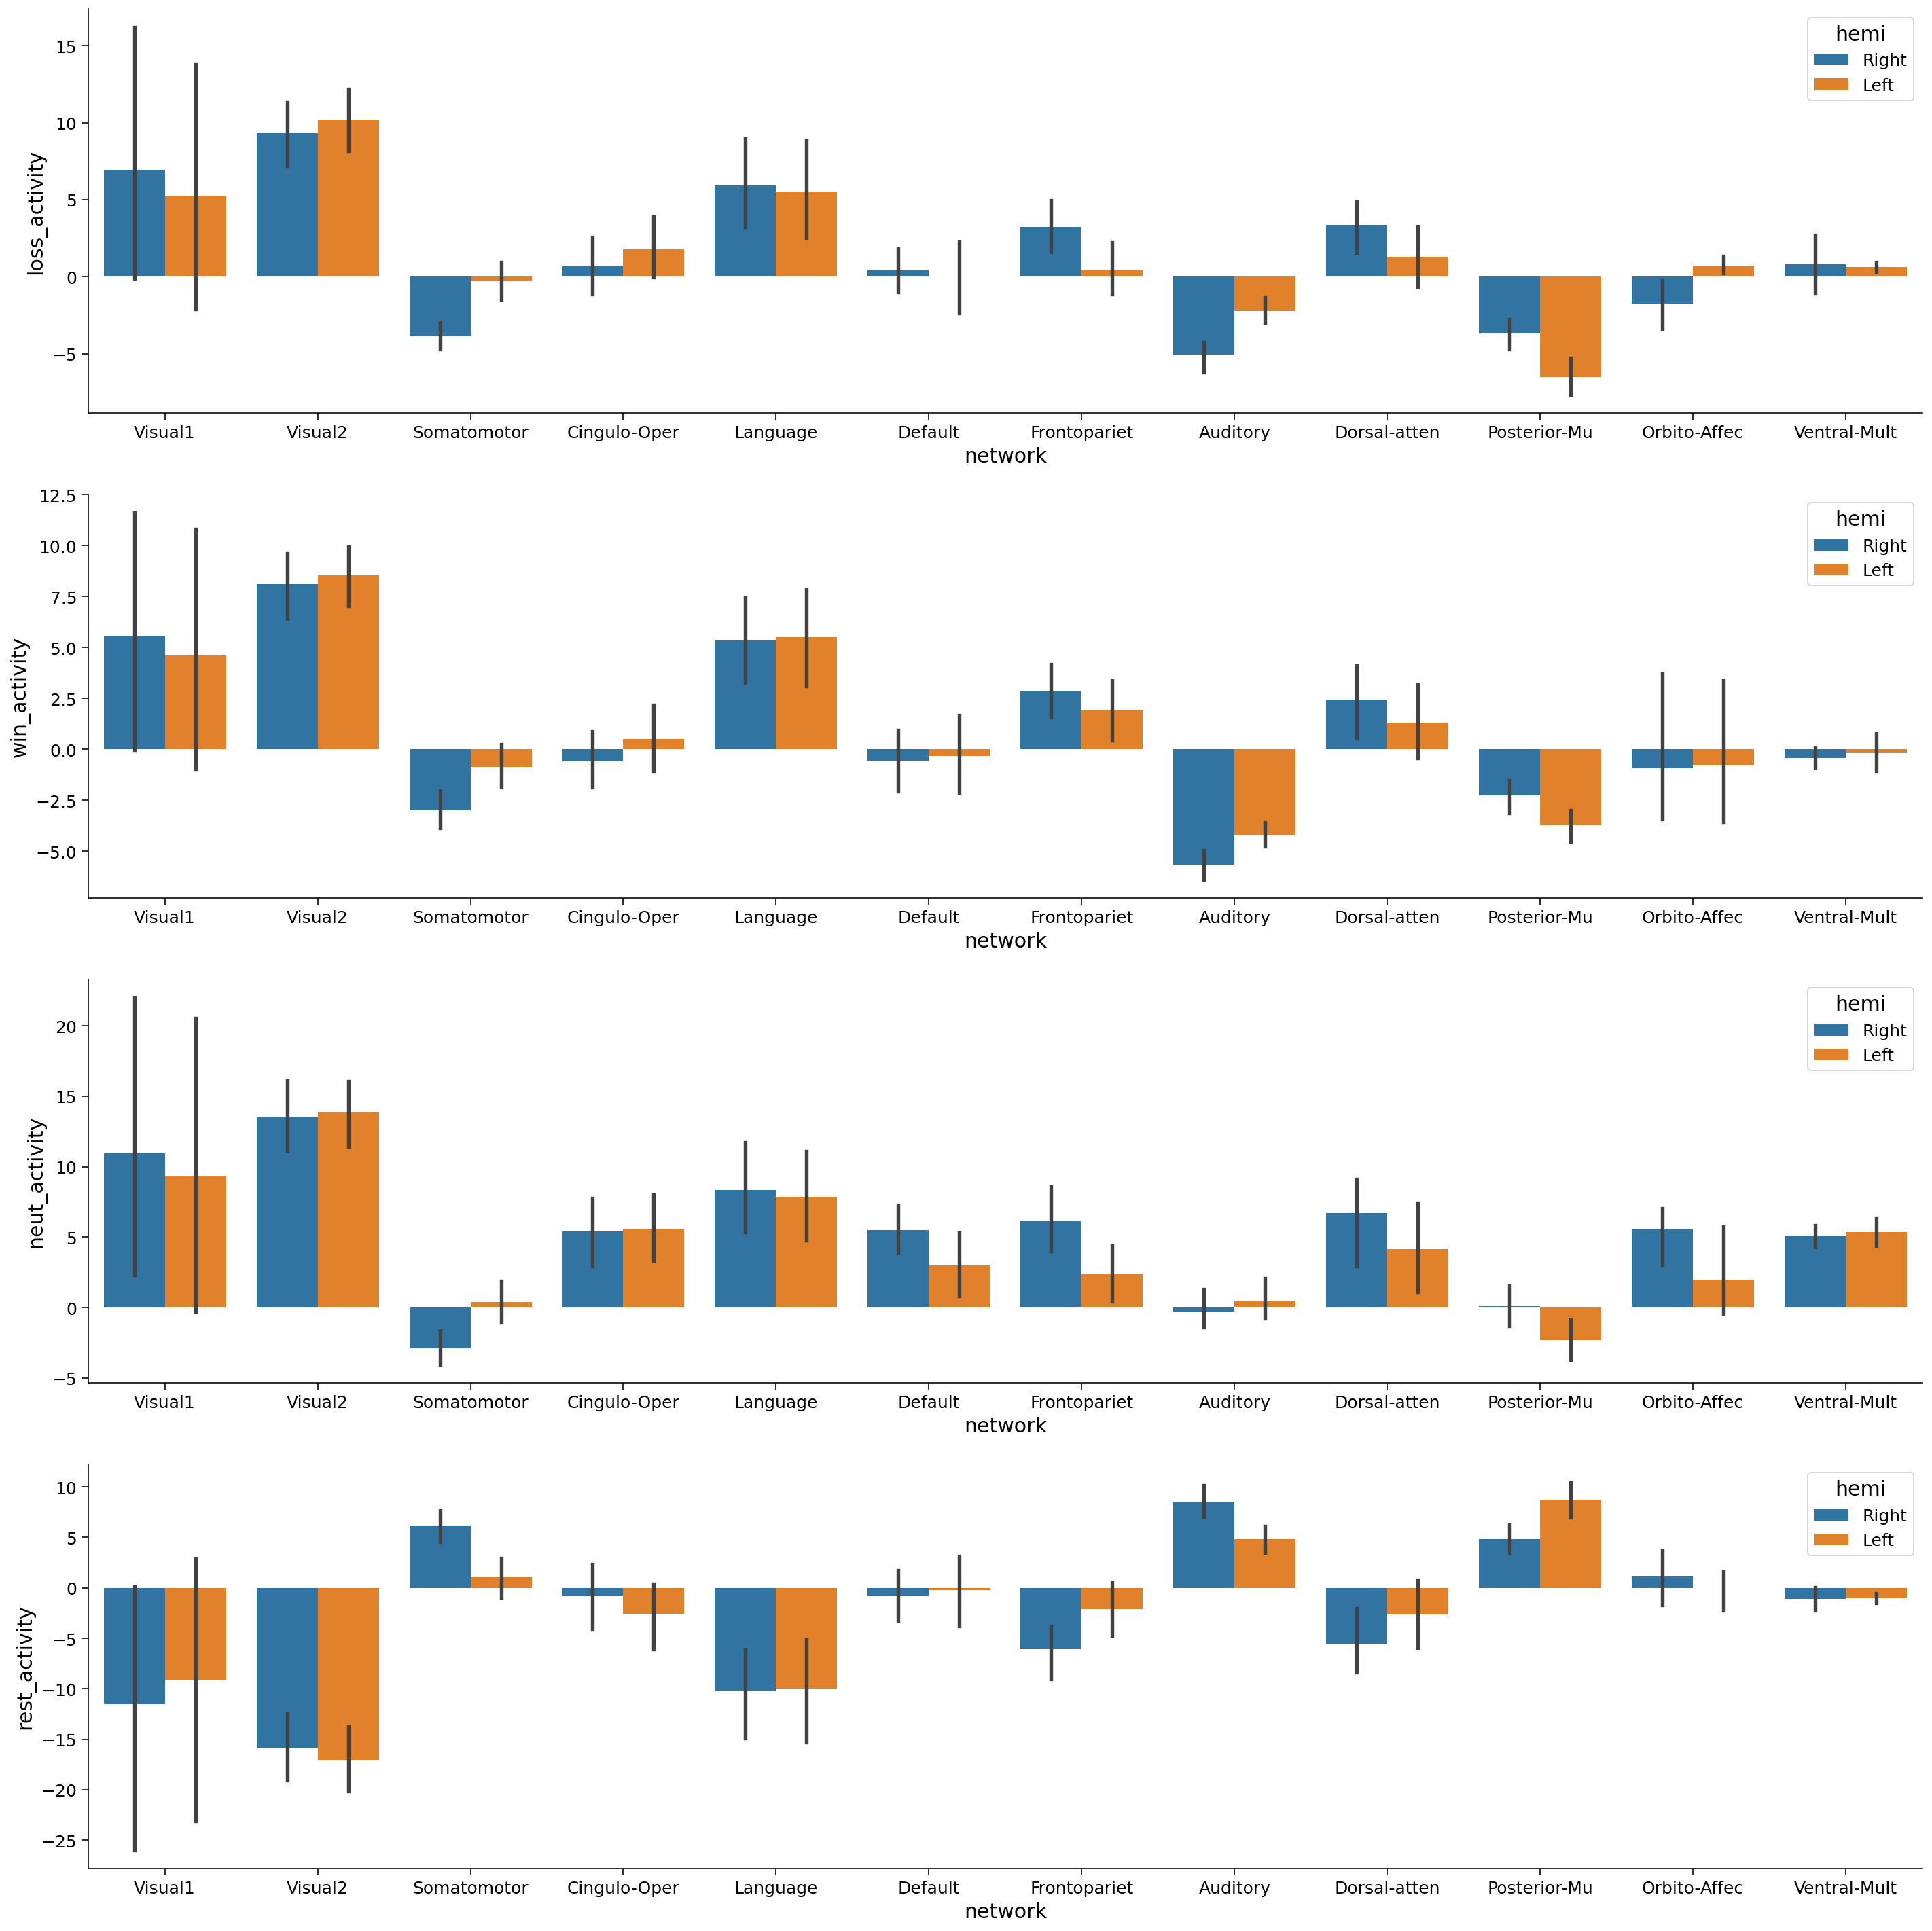

In [ ]:
df = pd.DataFrame({'loss_activity' : betas_avg_sub_run[0,:],
                   'win_activity'  : betas_avg_sub_run[1,:],
                   'neut_activity' : betas_avg_sub_run[2,:],
                   'rest_activity'  : betas_avg_sub_run[3,:],
                   'network'       : region_info['network'],
                   'hemi'          : region_info['hemi']})

fig,(ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize = (20,20))
sns.barplot(x='network', y='loss_activity', data=df, hue='hemi',ax=ax1)
sns.barplot(x='network', y='win_activity', data=df, hue='hemi',ax=ax2)
sns.barplot(x='network', y='neut_activity', data=df, hue='hemi',ax=ax3)
sns.barplot(x='network', y='rest_activity', data=df, hue='hemi',ax=ax4)

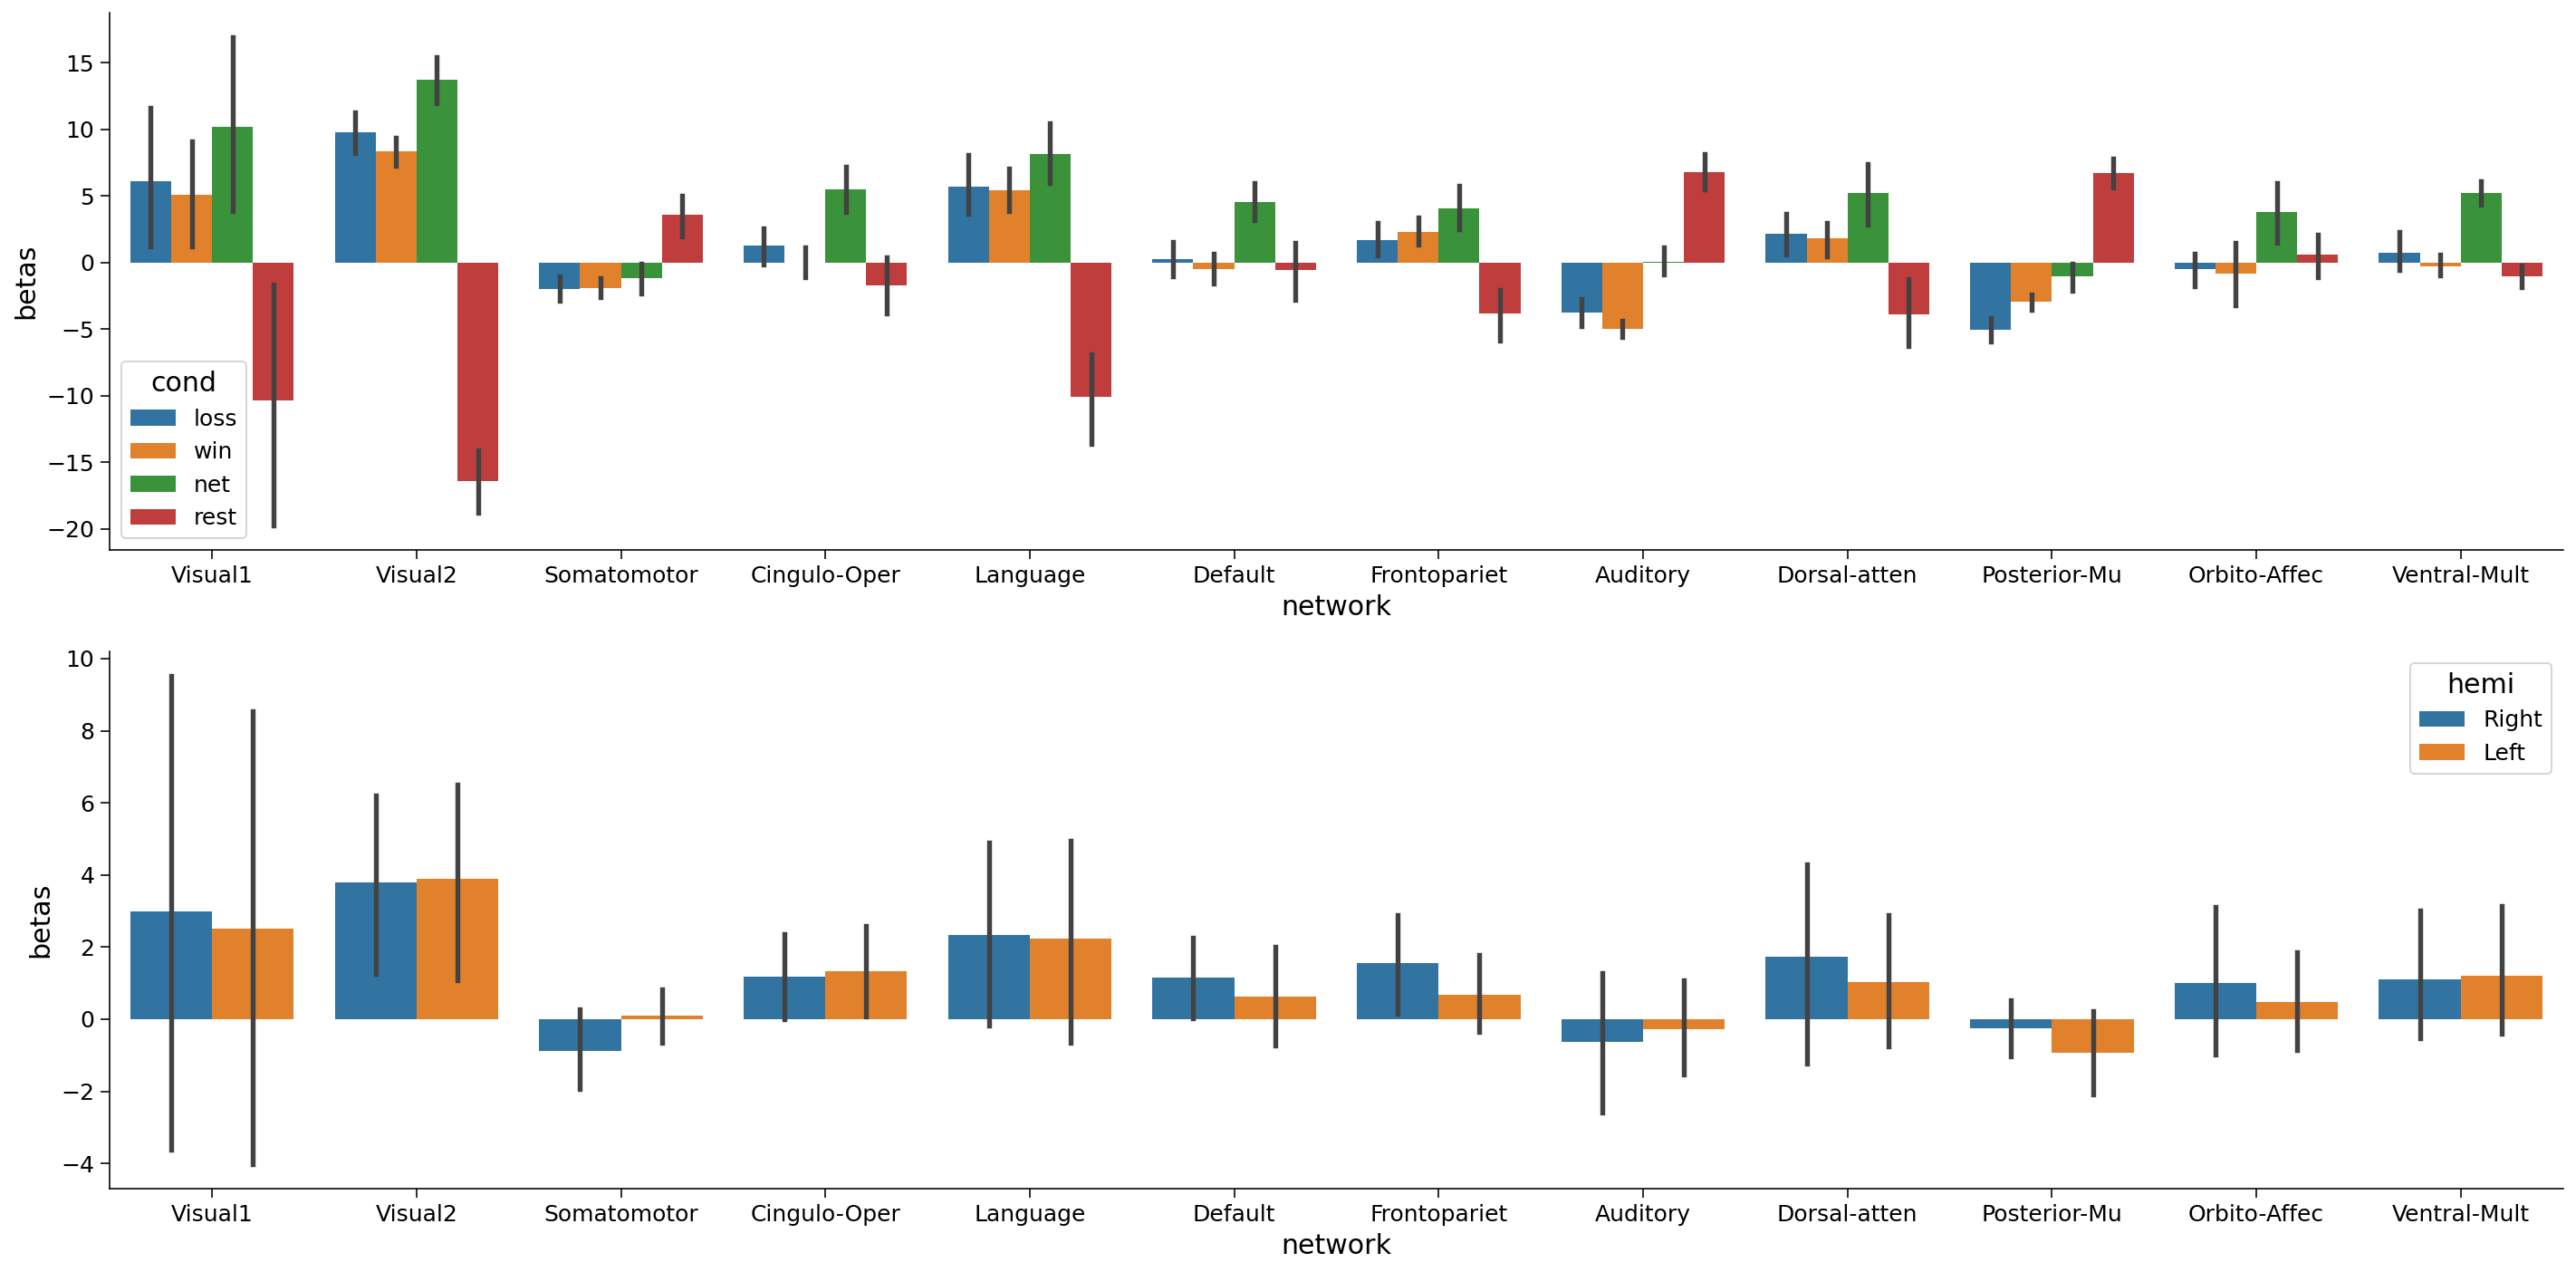

In [ ]:
df = pd.DataFrame({'betas'  : np.hstack((betas_avg_sub_run[0,:], betas_avg_sub_run[1,:], betas_avg_sub_run[2,:], betas_avg_sub_run[3,:])),
                   'cond'   : np.hstack((['loss']*360, ['win']*360, ['net']*360, ['rest']*360)),
                   'network': np.hstack((region_info['network'], region_info['network'], region_info['network'], region_info['network'])),
                   'name'   : np.hstack((region_info['name'], region_info['name'], region_info['name'], region_info['name'])),
                   'hemi'   : np.hstack((region_info['hemi'], region_info['hemi'], region_info['hemi'], region_info['hemi']))
                  })

fig, (ax1, ax2)= plt.subplots(2,1, figsize = (20,10))
sns.barplot(x='network', y='betas', data=df, hue='cond',ax=ax1)
sns.barplot(x='network', y='betas', data=df, hue='hemi',ax=ax2)

(4, 360)
(1, 360)


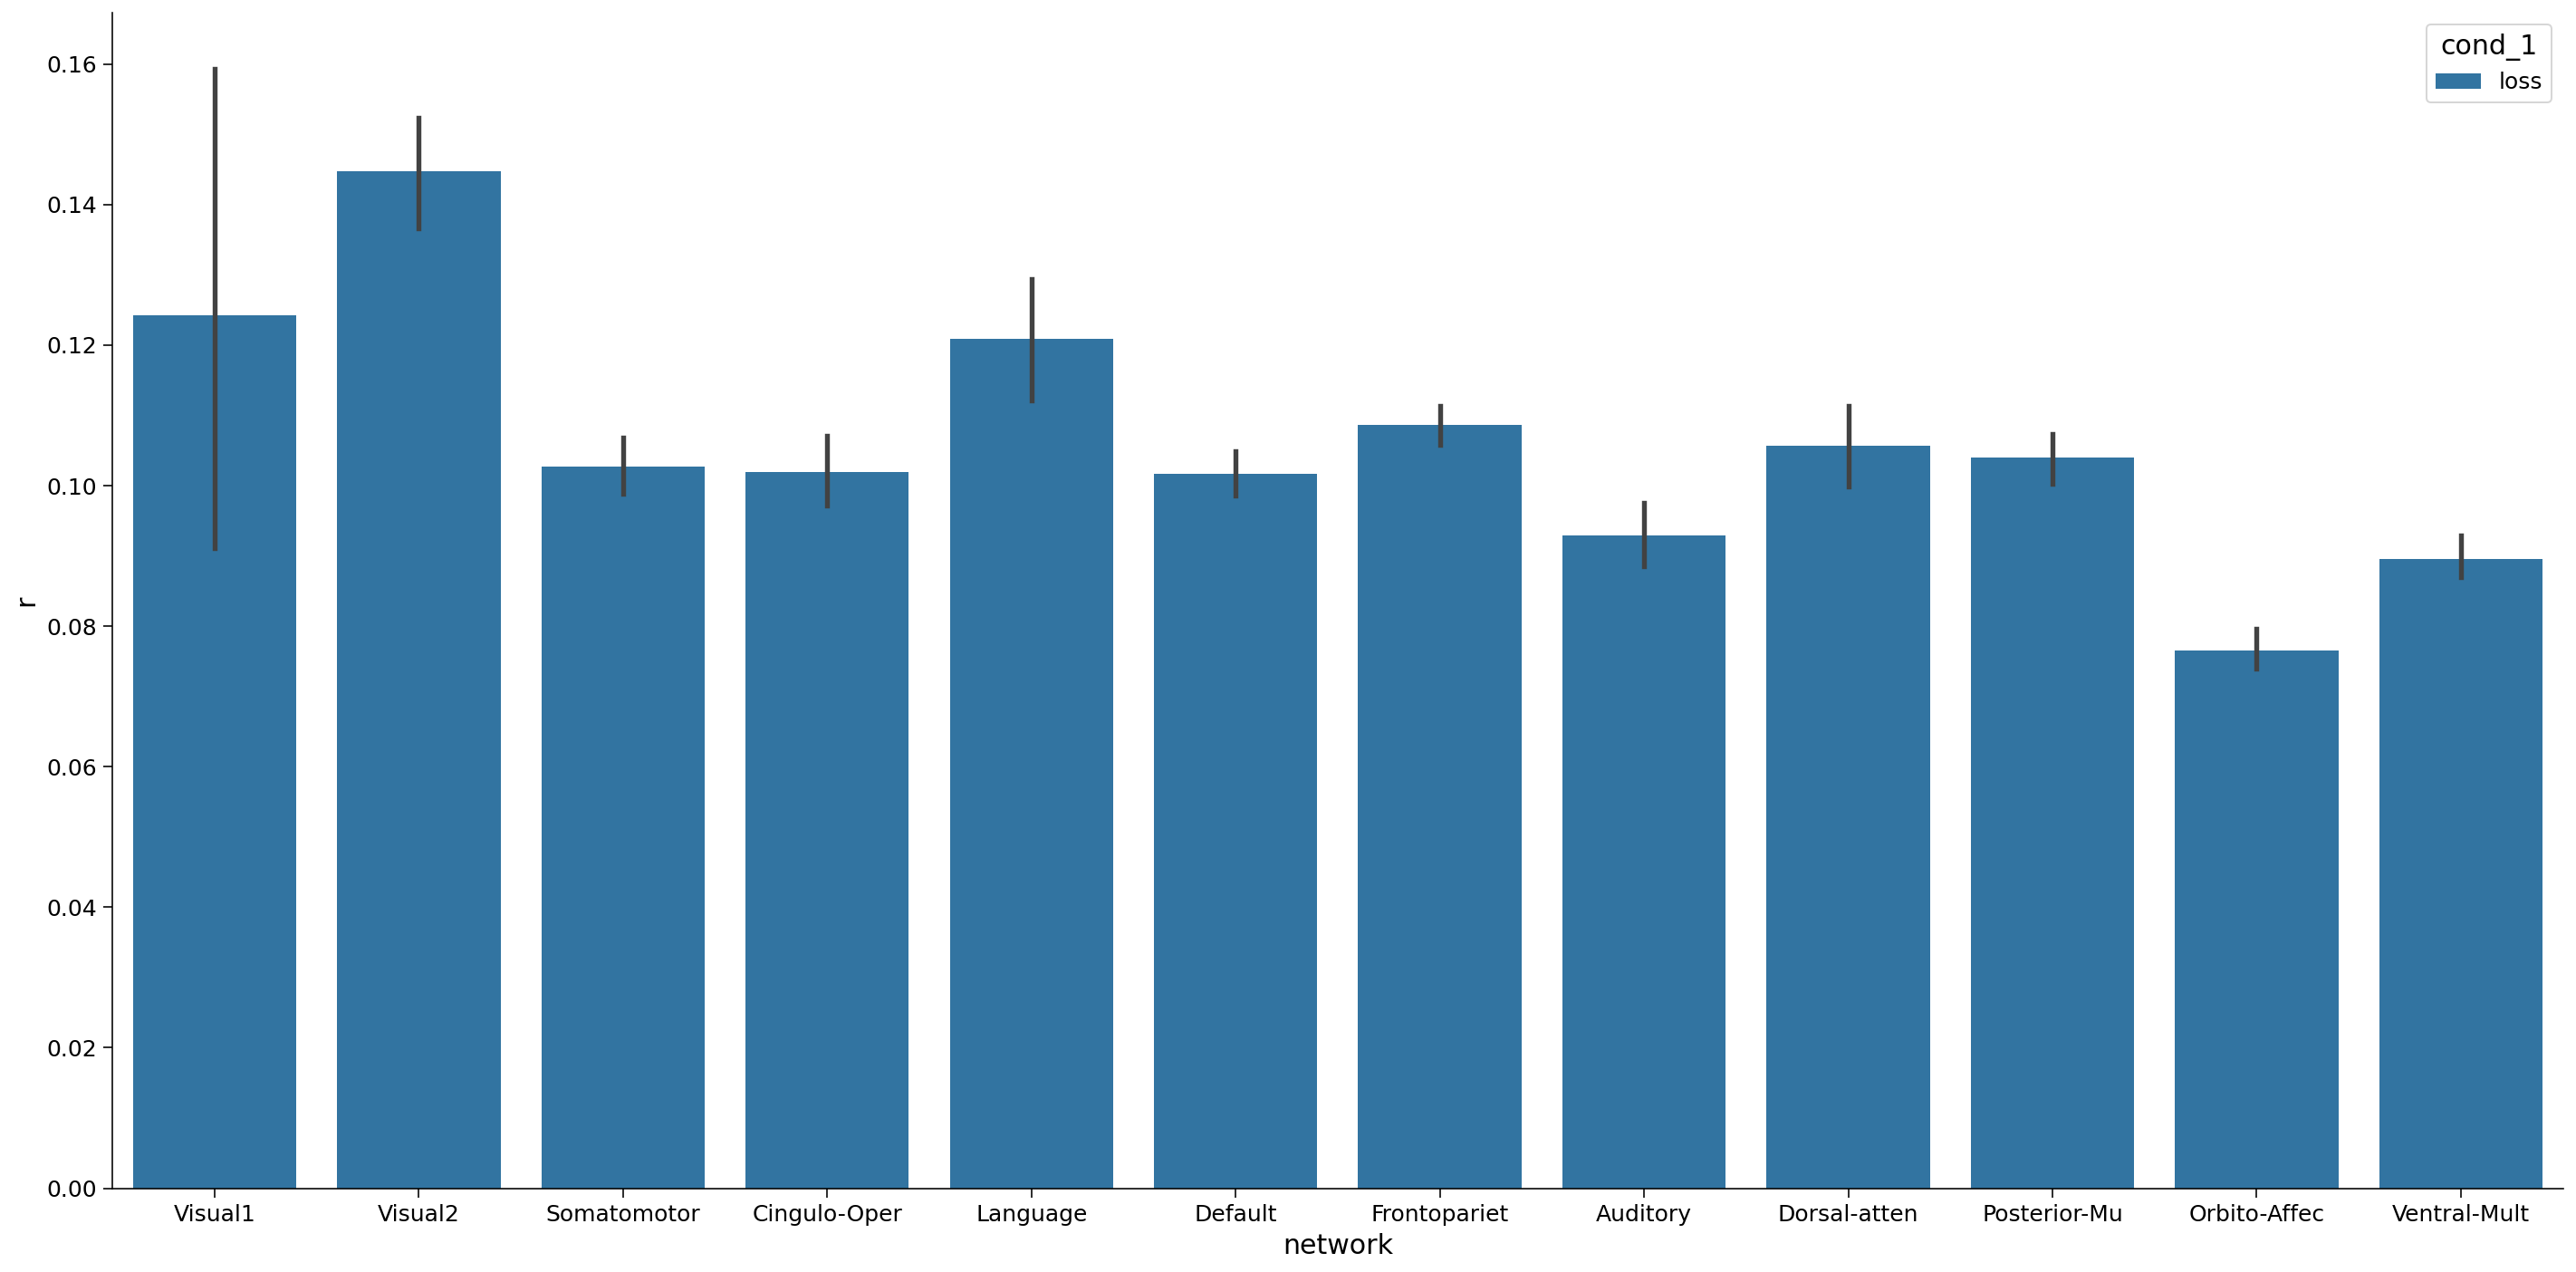

In [ ]:
print(betas_avg_sub_run.shape)
print(r_avg_sub_run.shape)

df_r_los = pd.DataFrame({  'r'  :  np.hstack((r_avg_sub_run_los)),
                    'cond_1'   : np.hstack((['loss']*360)),
                   #'cond_2'   : np.hstack((['r']*360)),
                   #'cond_3'   : np.hstack((['net']*360)),
                   'network': np.hstack((region_info['network'])),
                   'name'   : np.hstack((region_info['name'])),
                   'hemi'   : np.hstack((region_info['hemi']))
                  })


fig, (ax1)= plt.subplots(1,1, figsize = (20,10))
sns.barplot(x='network', y='r', data=df_r_los, hue='cond_1',ax=ax1)
#sns.barplot(x='network', y='r', data=df_r, hue='cond_2',ax=ax2)
#sns.barplot(x='network', y='r', data=df_r, hue='cond_3',ax=ax3)

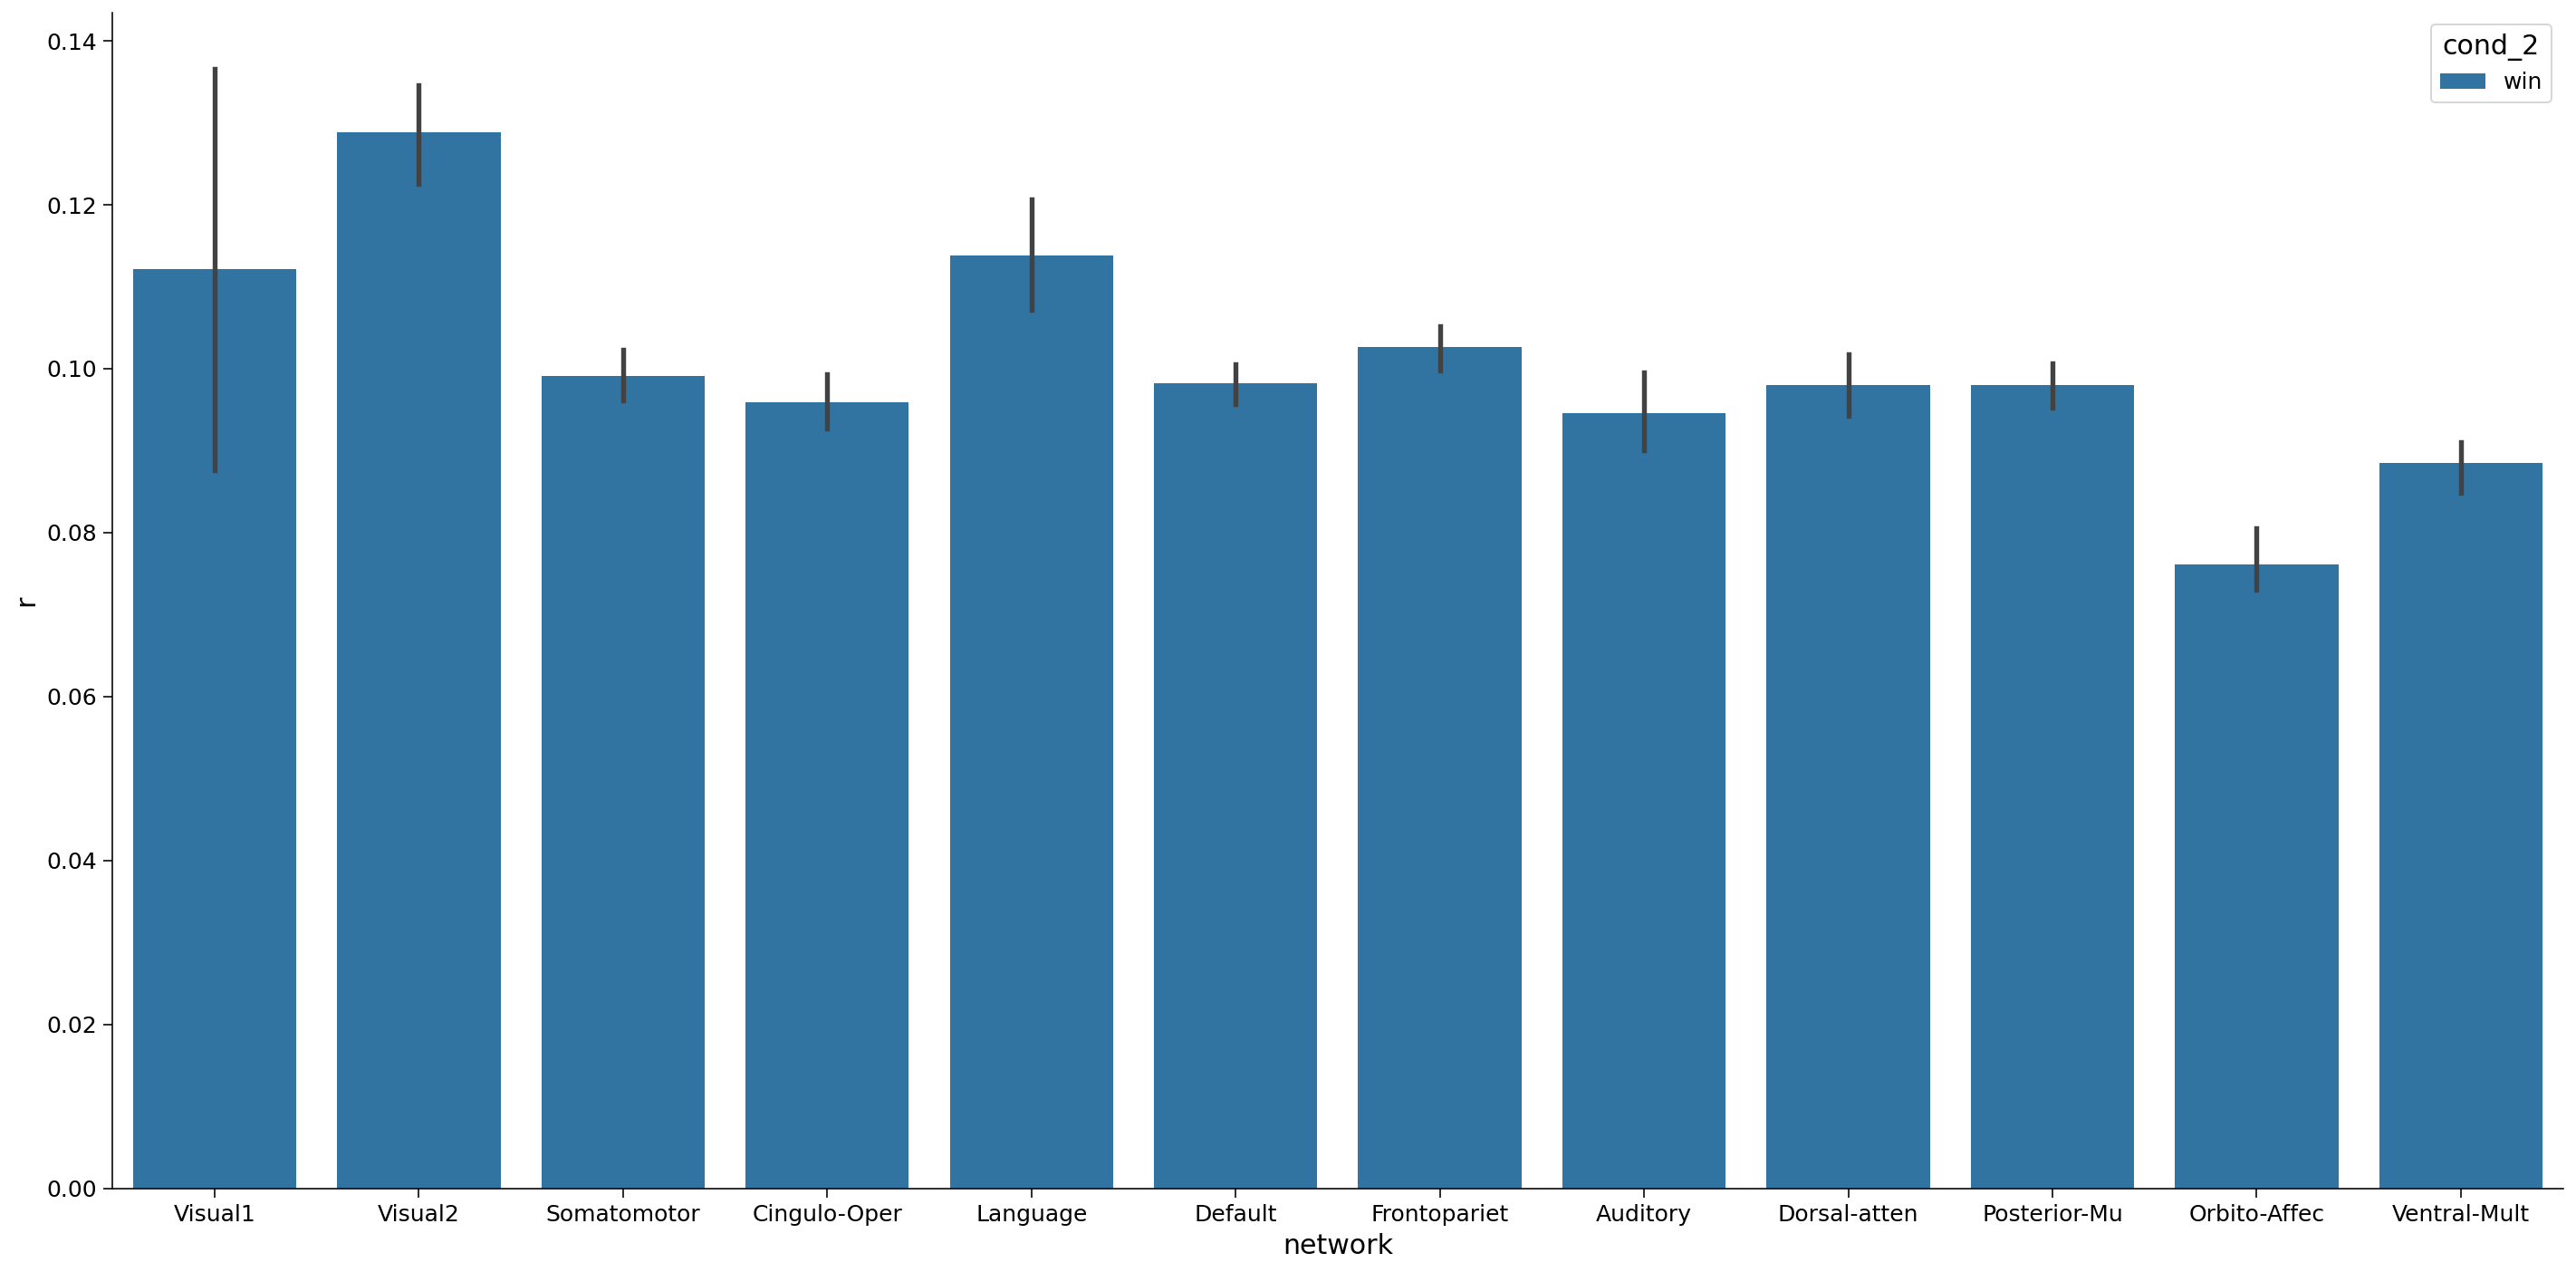

In [ ]:
df_r_win = pd.DataFrame({  'r'  :  np.hstack((r_avg_sub_run_win)),
                    #'cond_1'   : np.hstack((['los']*360)),
                    'cond_2'   : np.hstack((['win']*360)),
                   #'cond_3'   : np.hstack((['net']*360)),
                   'network': np.hstack((region_info['network'])),
                   'name'   : np.hstack((region_info['name'])),
                   'hemi'   : np.hstack((region_info['hemi']))
                  })


fig, (ax1)= plt.subplots(1,1, figsize = (20,10))
sns.barplot(x='network', y='r', data=df_r_win, hue='cond_2',ax=ax1)

In [ ]:
# we need a little function that averages all frames from any given condition
my_exp  = 'GAMBLING'
my_subj = 0
my_run  = 0

data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)
evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)
def average_frames(data, evs, experiment, cond):    
    idx = EXPERIMENTS[experiment]['cond'].index(cond)
    return np.mean(np.concatenate([np.mean(data[:,evs[idx][i]],axis=1,keepdims=True) for i in range(len(evs[idx]))],axis=-1),axis=1)

my_exp = "GAMBLING"
loss_activity = average_frames(data, evs, my_exp, 'loss')
win_activity = average_frames(data, evs, my_exp, 'win')
contrast    = loss_activity-win_activity   # difference between left and right hand movement

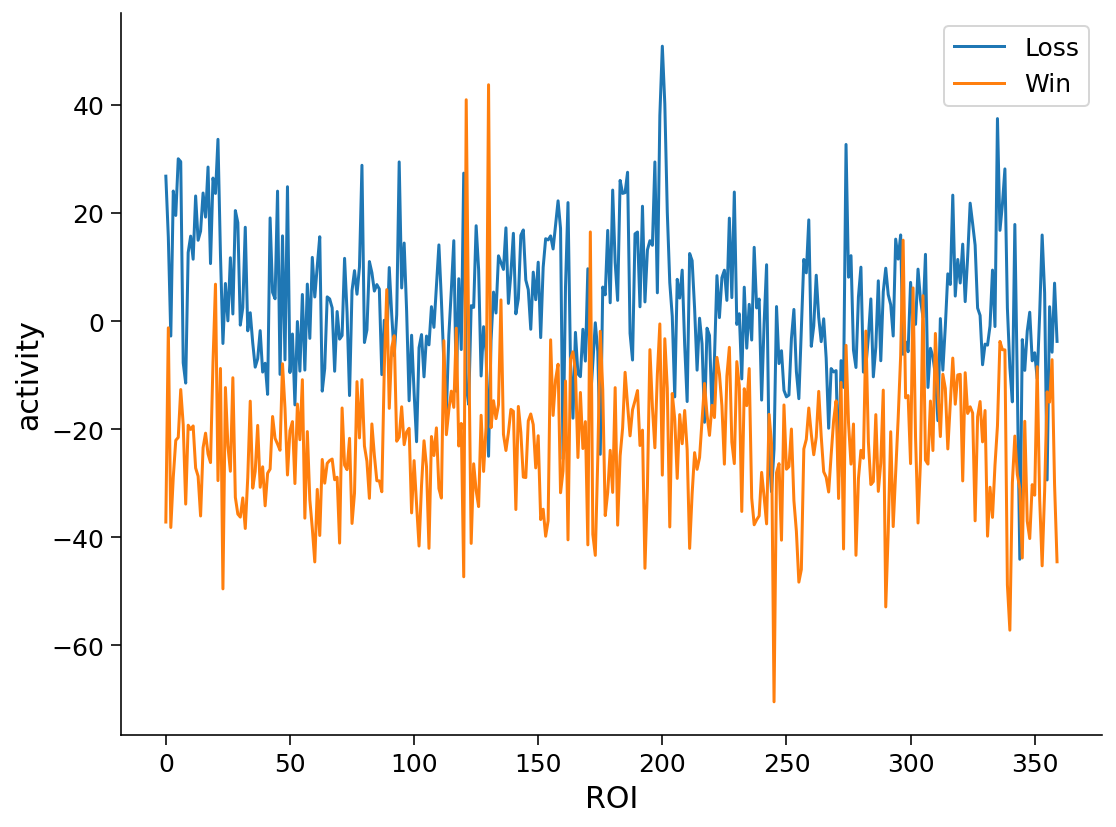

In [ ]:
# Plot activity level in each ROI for both conditions
plt.plot(loss_activity,label='Loss')
plt.plot(win_activity,label='Win')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()

In [ ]:
group_contrast = 0
for s in subjects:
  for r in [0,1]:
    data = load_single_timeseries(subject=s,experiment=my_exp,run=r,remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    lf_activity = average_frames(data, evs, my_exp, 'loss')
    rf_activity = average_frames(data, evs, my_exp, 'win')

    contrast    = lf_activity-rf_activity
    group_contrast        += contrast

group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject
print(group_contrast.shape)

(360,)


numpy.ndarray

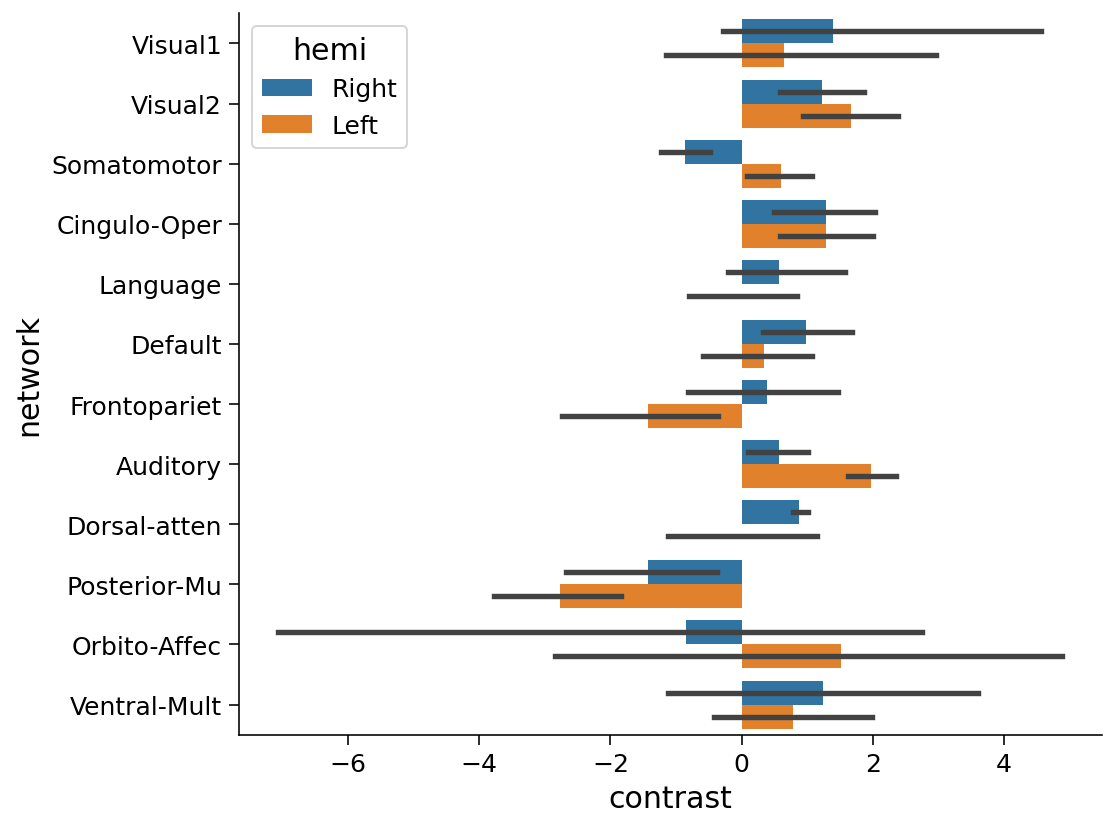

In [ ]:
df = pd.DataFrame({'contrast':group_contrast,'network':region_info['network'],'hemi':region_info['hemi']})
# we will plot the left foot minus right foot contrast so we only need one plot
sns.barplot(y='network', x='contrast', data=df, hue='hemi')


# Visualising the results on a brain

Finally, we will visualise these resuts on the cortical surface of an average brain.

In [ ]:

# This uses the nilearn package
!pip install nilearn --quiet
from nilearn import plotting, datasets

# NMA provides an atlas 
fname = f"{HCP_DIR}/atlas.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/j5kuc/download
with np.load(fname) as dobj:
  atlas = dict(**dobj)

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = r[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=1)


IndexError: ignored